In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Sapienza/CV

/content/drive/MyDrive/Sapienza/CV


## Loading the saved data using the pickle library

In [ ]:
import pickle
import pandas as pd
import numpy as np
import json
import itertools
import gensim

with open('datax.pkl', 'rb') as handle:
    X = pickle.load(handle)

with open('labelsx.pkl', 'rb') as handle:
    y = pickle.load(handle)

print(X.shape)
print(y.shape)

(9672, 128, 128, 3)
(9672,)


## Installing libraries and basic checks

In [ ]:
!nvidia-smi

Tue Jun 28 13:29:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


## Changing labels to 1,0 and 0,1 format for using it for the softmax actication function.

In [ ]:
y1=[]
for val in y:
  if val==0:
    y1.append([1,0])
  else:
    y1.append([0,1])
y=np.array(y1)
y[:2]

array([[1, 0],
       [1, 0]])

## Using 33% data for testing and 77% data for training

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


In [ ]:
num_classes = 2
input_shape = X.shape[1:]
input_shape

(128, 128, 3)

In [ ]:
# vision transformers code taken from https://keras.io/examples/vision/image_classification_with_vision_transformer/

#params for vision transformer
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 50
image_size = 128
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 2
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 2
mlp_head_units = [512, 256] 

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(X_train) # using data augmentation

In [ ]:
# adding MLP layers
count=0
def mlp(x, hidden_units, dropout_rate):
    global count
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu, name='feats'+str(count))(x)
        x = layers.Dropout(dropout_rate)(x)
        count+=1
    return x

In [ ]:
count

0

In [ ]:
# generating patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
X_train[0]

array([[[0.58039216, 0.55686275, 0.71764706],
        [0.61176471, 0.58039216, 0.74117647],
        [0.62745098, 0.59607843, 0.75294118],
        ...,
        [0.66666667, 0.65098039, 0.78823529],
        [0.63921569, 0.64313725, 0.77647059],
        [0.65490196, 0.63921569, 0.76470588]],

       [[0.58431373, 0.56470588, 0.71764706],
        [0.60784314, 0.58823529, 0.74117647],
        [0.61568627, 0.59607843, 0.74901961],
        ...,
        [0.69803922, 0.67058824, 0.81568627],
        [0.65882353, 0.64705882, 0.78039216],
        [0.65882353, 0.64705882, 0.77254902]],

       [[0.58039216, 0.55686275, 0.71764706],
        [0.61176471, 0.58823529, 0.74509804],
        [0.61176471, 0.59215686, 0.74509804],
        ...,
        [0.68235294, 0.66666667, 0.80784314],
        [0.6627451 , 0.64705882, 0.78431373],
        [0.65882353, 0.63921569, 0.76470588]],

       ...,

       [[0.62745098, 0.61176471, 0.7254902 ],
        [0.63137255, 0.61176471, 0.73333333],
        [0.66666667, 0

rnd:  3105


(-0.5, 127.5, 127.5, -0.5)

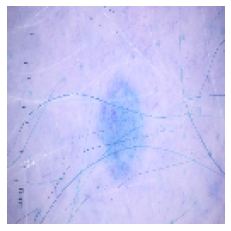

In [ ]:
import matplotlib.pyplot as plt
# visualizing an image in BGR mode
plt.figure(figsize=(4, 4))
rnd=np.random.choice(range(X_train.shape[0]))
print("rnd: ", rnd)
image = X_train[rnd]*255.0
plt.imshow(image.astype("uint8"))
plt.axis("off")


Image size: 128 X 128
Patch size: 6 X 6
Patches per image: 441
Elements per patch: 108


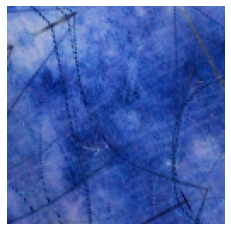

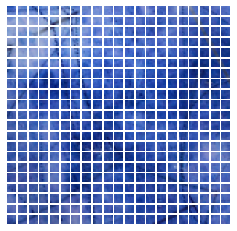

In [ ]:
# displaying patches of the image
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]*255.0
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# encoding the patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    j=0
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
        j+=1

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.2)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.4)
    # Classify outputs.
    logits = layers.Dense(num_classes,activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.summary()
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            "accuracy"
        ]
    )

    early_stop=EarlyStopping(monitor="val_loss",
                         patience=5,
                         mode="auto",restore_best_weights=True)

    callbacks=[early_stop]

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=[X_test,y_test], callbacks=callbacks
    )

    return history

#make the Vit classifier
vit_classifier = create_vit_classifier()


In [ ]:
history = run_experiment(vit_classifier)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 128, 128, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 441, 64)      35200       ['patches_1[0][0]']          

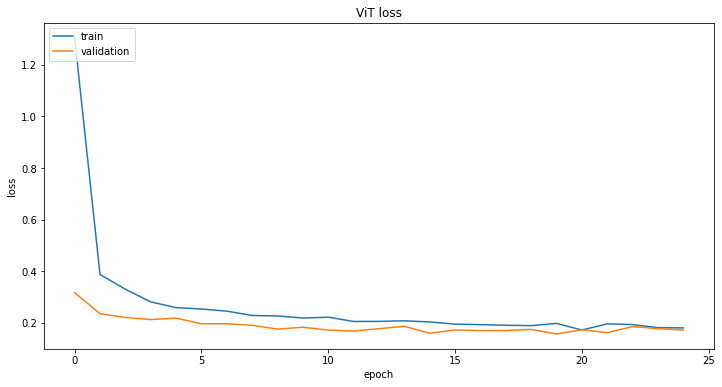

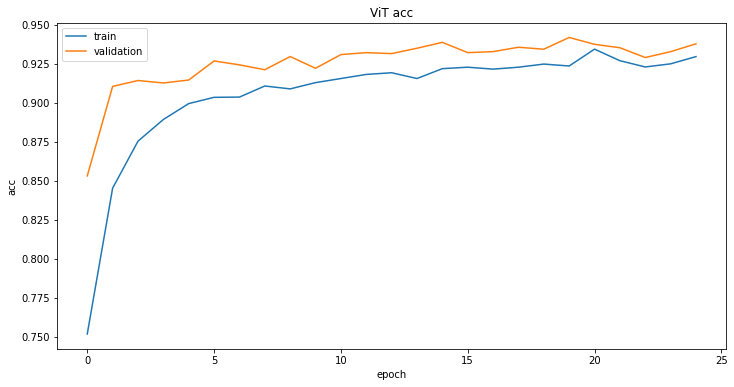

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#plot loss and acc
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ViT loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12,6))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('ViT acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [ ]:
preds=vit_classifier.predict(X_test) # get predictions
p=np.argmax(preds,axis=1)
t=np.argmax(y_test,axis=1)
p.shape

(3192,)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(t,p))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1629
           1       0.97      0.91      0.94      1563

    accuracy                           0.94      3192
   macro avg       0.94      0.94      0.94      3192
weighted avg       0.94      0.94      0.94      3192



In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(t,p)


[Text(0, 0.5, 'Benign'), Text(0, 1.5, 'Malignant')]

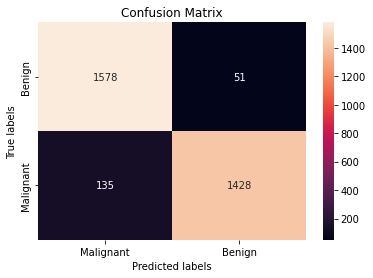

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     
labs=['Malignant', 'Benign']

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['Malignant', 'Benign'])
ax.yaxis.set_ticklabels(['Benign', 'Malignant'])